- KEYWORDS: energy balance, pfr


![img](//s-media-cache-ak0.pinimg.com/736x/74/f9/9f/74f99f04041456063f6084b1b5c811d2.jpg)

# The energy balance and the PFR

-   For the plug flow reactor the energy balance we will use for a single reaction is

<div class="alert alert-warning">
$ \frac{dT}{dV} = \frac{-\Delta H_{Rx}(T) r + \dot{Q}}{\sum F_i C_{P,i}} $
</div>
![img](https://raw.githubusercontent.com/jkitchin/s17-06364/master/lectures/images/differential-pfr-eb.png)

-   This will in general just add an equation to the mole balance to be solved simultaneously

## An adiabatic plug flow reactor example

-   We consider the endothermic reaction $A \rightarrow B + C$ in an adiabatic PFR ($\dot{Q} = 0$)

The data for this reaction is provided here:

In [1]:
import numpy as np
from scipy.integrate import odeint
%matplotlib inline
import matplotlib.pyplot as plt

Fa0 = 0.0376      # mol/s
Ca0 = 0.0188      # mol / L

v0 = Fa0 / Ca0    # initial volumetric flow
Ft0 = Fa0

T0 = 1035.0       # K

# thermal properties
Hrxn_298 = 80.77   # kJ/mol at 298K
Cpa = 0.1630       # kJ/mol/K
Cpb = 0.083
Cpc = 0.071

We need a mole and energy balance. One equation for the molar flow of A, and one for the temperature.

Some important points:

-   We need to account for the temperature dependent volumetric flow
-   So we can use it to compute the concentration of A
-   We also need the temperature dependent rate constant
-   For use in the rate law

In [6]:
def adiabatic_pfr(Y, V):
    Fa, T = Y  # unpack variables

    extent = (Fa - Fa0) / (-1.0)
    Fb = extent
    Fc = extent

    Ft = Fa + Fb + Fc

    # include temperature in the volumetric flow
    v = v0 * Ft / Ft0 * T / T0

    # reaction rate
    k = np.exp(34.3 - 34222.0 / T)
    Ca = Fa / v
    r = k * Ca
    ra = -r  # species rate

    # thermodynamic reaction energy
    Hrxn = Hrxn_298 + (Cpb + Cpc - Cpa) * (T - 298.0)

    dFadV = ra
    dTdV = 0 #(-Hrxn * r) / (Fa * Cpa + Fb * Cpb + Fc * Cpc)

    return [dFadV, dTdV]


Vspan = np.linspace(0, 30) # volume in L
Y0 = [Fa0, T0]

sol = odeint(adiabatic_pfr, Y0, Vspan)

Fa = sol[:, 0]
T = sol[:, 1]

X = ((Fa - Fa0) * (-1) / Fa0)

I find it helpful and more readable to split the code blocks up.

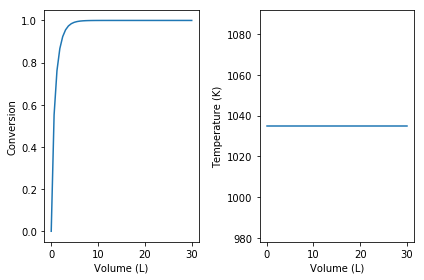

In [7]:
plt.subplot(1, 2, 1)
plt.plot(Vspan, X)
plt.xlabel('Volume (L)')
plt.ylabel('Conversion')

plt.subplot(1, 2, 2)
plt.plot(Vspan, T)
plt.xlabel('Volume (L)')
plt.ylabel('Temperature (K)')

plt.tight_layout()

-   Low conversion results because the temperature drops rapidly due to the endothermic reaction.

## Using inerts to provide heat to an endothermic reaction

-   Let us reconsider the example with an inert gas
-   The gas is chosen to be inert, and to have  higher heat capacity
-   The inert gas serves as a thermal reservoir to buffer the temperature loss

We use the same data. We redefine it here in case anything was changed in a block above this one.

In [10]:
Fa0 = 0.0376      # mol/s
Ca0 = 0.0188      # mol / L

v0 = Fa0 / Ca0    # initial volumetric flow
Ft0 = Fa0

T0 = 1035.0       # K

Hrxn_298 = -80.77  # kJ/mol at 298K
Cpa = 0.1630      # kJ/mol/K
Cpb = 0.083
Cpc = 0.071
Cpi = 0.100       # inert

The main difference here is the addition of inerts.

In [14]:
def adiabatic_pfr(Y, V, Fi0):
    Fa, T = Y  # unpack variables

    extent = (Fa - Fa0) / (-1.0)
    Fb = extent
    Fc = extent

    Ft = Fa + Fb + Fc + Fi0
    Ft0 = Fa0 + Fi0

    v = v0 * Ft / Ft0 * T / T0

    k = np.exp(34.3 - 34222.0 / T)
    Ca = Fa / v
    r = k * Ca
    ra = -r
    Hrxn = Hrxn_298 + (Cpb + Cpc - Cpa) * (T - 298.0)

    dFadV = ra
    dTdV = (-Hrxn * r) / (Fa * Cpa + Fb * Cpb + Fc * Cpc + Fi0 * Cpi)

    return [dFadV, dTdV]


Vspan = np.linspace(0, 2) # volume in L
Y0 = [Fa0, T0]

We examine three flow rates of inerts in a loop.

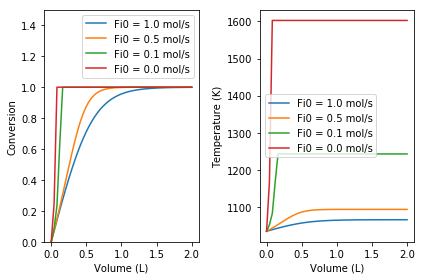

In [15]:
for i, Fi0 in enumerate([1.0, 0.5, 0.1, 0.0]):
    sol = odeint(adiabatic_pfr, Y0, Vspan, args=(Fi0,))

    Fa = sol[:, 0]
    T = sol[:, 1]

    X = ((Fa - Fa0) * (-1) / Fa0)

    plt.subplot(1,2,1)
    plt.plot(Vspan, X,  label='Fi0 = {0} mol/s'.format(Fi0))
    plt.xlabel('Volume (L)')
    plt.ylabel('Conversion')

    plt.subplot(1,2,2)
    plt.plot(Vspan, T,  label='Fi0 = {0} mol/s'.format(Fi0))
    plt.xlabel('Volume (L)')
    plt.ylabel('Temperature (K)')

plt.subplot(1,2,1)
plt.ylim([0, 1.5])
plt.legend(loc='best')

plt.subplot(1,2,2)
#plt.ylim([900, 1100])
plt.legend(loc='best')

plt.tight_layout()

-   Note that now we can get much higher conversion

-   The downside is we have a high concentration of inerts

-   There may be separation costs to consider

-   There will be increased flow rates due to the extra molar flow
    -   May have to consider pressure drops

-   A similar behavior is observed with exothermic reactions

-   The inert gas can *absorb* heat from the reaction

## Constant temperature heat exchanger

-   We can avoid the need for inert thermal buffers by using heat exchangers
-   The simplest heat exchanger for the PFR is an ambient exchanger
-   The PFR is embedded in a constant temperature environment
-   We will typically describe $\dot{Q} = U a (T_a - T)$
-   The energy balance is

$ \frac{dT}{dV} = \frac{-\Delta H_{rx}(T) r + U a (T_a - T)}{\sum F_i C_{p,i}} $

-   We choose a sign convention so that we *add* $\dot{Q}$
-   If $T_a > T$ we expect the contribution to $\frac{dT}{dV}$ to be positive, i.e. the temperature increases.
-   Let us reconsider the last example, with no inerts but in an ambient heat exchanger with
-   Ua = 0.0165 kJ/L/s/K
-   T\_a = 1150 K
-   The heat exchanger is hotter than the feed, so we anticipate it should transfer heat to the reactor
-   That should counterbalance the loss of temperature due to the endothermic reaction

In [23]:
Fa0 = 0.0376      # mol/s
Ca0 = 0.0188      # mol / L

v0 = Fa0 / Ca0    # initial volumetric flow
Ft0 = Fa0

T0 = 1035.0       # K

Hrxn_298 = 80.77  # kJ/mol at 298K
Cpa = 0.1630      # kJ/mol/K
Cpb = 0.083
Cpc = 0.071

Ta = 1080.0       # ambient heat exchanger temperature
Ua = 0.0165       # overall heat transfer coefficient

The mole/energy balance is pretty standard, but we add the $\dot{Q}$ term to the energy balance.

In [24]:
def pfr(Y, V):
    Fa, T = Y  # unpack variables

    extent = (Fa - Fa0) / (-1.0)
    Fb = extent
    Fc = extent

    Ft = Fa + Fb + Fc

    v = v0 * Ft / Ft0 * T / T0

    k = np.exp(34.3 - 34222.0 / T)
    Ca = Fa / v
    r = k * Ca
    ra = -r
    Hrxn = Hrxn_298 + (Cpb + Cpc - Cpa) * (T - 298.0)

    dFadV = ra

    Qdot = Ua * (Ta - T)
    dTdV = (-Hrxn * r + Qdot) / (Fa * Cpa + Fb * Cpb + Fc * Cpc)

    return [dFadV, dTdV]


Vspan = np.linspace(0, 5) # volume in L
Y0 = [Fa0, T0]

sol = odeint(pfr, Y0, Vspan)

Fa = sol[:, 0]
T = sol[:, 1]

X = ((Fa - Fa0) * (-1) / Fa0)

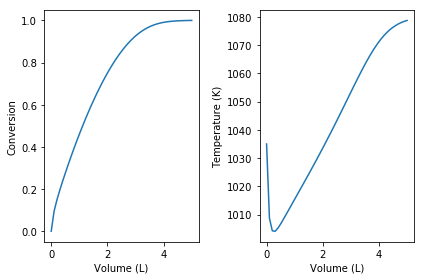

In [25]:
plt.subplot(1,2,1)
plt.plot(Vspan, X)
plt.xlabel('Volume (L)')
plt.ylabel('Conversion')

plt.subplot(1,2,2)
plt.plot(Vspan, T)
plt.xlabel('Volume (L)')
plt.ylabel('Temperature (K)')

plt.tight_layout()

-   Note that now we get complete conversion at a low reactor volume

-   There is initially a drop in temperature where the reaction rate is fast near the entrance of the reactor

-   As the rate slows due to consumption of A, the temperature increases until it is the same as the ambient heat exchanger

-   Ambient heat exchangers are simple, but not particularly efficient
    -   Energy goes into heating the entire stream

## Shell and tube cocurrent heat exchanger

-   A more sophisticated heat exchanger is a shell and tube design
-   We first consider the cocurrent design

![img](https://raw.githubusercontent.com/jkitchin/s17-06364/master/lectures/images/cocurrent-tube-shell.png)

-   The temperature in the shell is not constant, it changes down the length of the tube
-   That means we need another equation for the temperature in the shell
-   All the heat that goes into the tube must come from the shell
-   So our energy balance on the shell becomes

$ \frac{dT_{shell}}{dV} = \frac{-\dot{Q}}{\dot{m} C_{p,coolant}} $

-   where $\dot{m}$ is the mass flow of coolant
-   $C_{p,coolant}$ is the heat capacity (on mass basis of coolant)
-   $T$  is the tube temperature
-   This simply adds a third equation
-   It is coupled to the energy balance of the tube through $T$
-   Let us use a molar flow rate of 1 mol / s coolant with a heat capacity of 0.0345 kJ / mol / K in a cocurrent tube and shell reactor
-   This is still a set of ordinary differential equations, with initial conditions on each variable.

In [26]:
Fa0 = 0.0376      # mol/s
Ca0 = 0.0188      # mol / L

v0 = Fa0 / Ca0    # initial volumetric flow
Ft0 = Fa0

T0 = 1035.0       # K

Hrxn_298 = 80.77  # kJ/mol at 298K
Cpa = 0.1630      # kJ/mol/K
Cpb = 0.083
Cpc = 0.071

Tshell0 = 1150.0    # ambient heat exchanger temperature
Ua = 0.0165         # overall heat transfer coefficient
mdot = 1.0          # mol/s coolant flow rate
Cpcoolant = 0.0345  # Heat capacity of coolant

Note the extra variable in the ODE function for the shell temperature. There is also an extra equation on the shell energy balance.

In [27]:
def pfr(Y, V):
    Fa, T, Tshell = Y  # unpack variables

    extent = (Fa - Fa0) / (-1.0)
    Fb = extent
    Fc = extent

    Ft = Fa + Fb + Fc

    v = v0 * Ft / Ft0 * T / T0

    k = np.exp(34.3 - 34222.0 / T)
    Ca = Fa / v
    r = k * Ca
    ra = -r
    Hrxn = Hrxn_298 + (Cpb + Cpc - Cpa) * (T - 298.0)

    dFadV = ra

    Qdot = Ua * (Tshell - T)
    
    # Tube energy balance
    dTdV = (-Hrxn * r + Qdot) / (Fa * Cpa + Fb * Cpb + Fc * Cpc)
    
    # shell energy balance
    dTshelldV = -Qdot / (mdot * Cpcoolant)

    return [dFadV, dTdV, dTshelldV]

Vspan = np.linspace(0, 5) # volume in L
Y0 = [Fa0, T0, Tshell0]
sol = odeint(pfr, Y0, Vspan)

Fa = sol[:, 0]
T = sol[:, 1]
Tshell = sol[:, 2]
X = ((Fa - Fa0) * (-1) / Fa0)

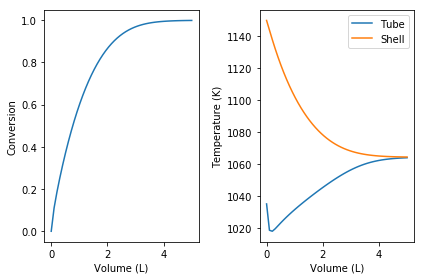

In [28]:
plt.subplot(1,2,1)
plt.plot(Vspan, X)
plt.xlabel('Volume (L)')
plt.ylabel('Conversion')

plt.subplot(1,2,2)
plt.plot(Vspan, T, label='Tube')
plt.plot(Vspan, Tshell, label='Shell')
plt.xlabel('Volume (L)')
plt.ylabel('Temperature (K)')
plt.legend(loc='best')

plt.tight_layout()

-   You can see the shell temperature decreases along the volume

-   The tube temperature initially dips slightly, then increases until the tube and shell temperatures are the same

-   At that point, there is no heat transfer between them

## Shell and tube countercurrent heat exchanger (optional)

-   Counter-current heat exchangers use heat more efficiently than co-current exchangers

![img](https://raw.githubusercontent.com/jkitchin/s17-06364/master/lectures/images/counter-current-tube-shell.png)

-   You provide the greatest heat transfer where it is needed
    -   For an endothermic reaction this is where the reactor is coldest
    -   If you are cooling, this is where the reactor is the hottest
-   However, they are much harder problems to solve because we have:

\begin{align*}
F_A(0) &=& F_{A0} \\
T(V=0) &=& T_0 \\
T_{shell}(V=L) &=& T_{shell,inlet}
\end{align*}

-   In other words, we do not have an initial value problem anymore!
-   We have a boundary value problem
-   It is also the case that the energy balance on the shell is different than the cocurrent case by a sign change
-   This happens because the flow is going in the opposite direction as in the tube

$ \frac{dT_{shell}}{dV} = \frac{\dot{Q}}{\dot{m} C_{p,coolant}} $

-   Solving boundary value problems is generally difficult
-   A notable weakness in Python at the moment is the lack of strong boundary value problem solvers
-   Pycse has some capabilities for solving BVPs, but not this one
-   We use a simple, iterative shooting method here

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

Fa0 = 0.0376      # mol/s
Ca0 = 0.0188      # mol / L

v0 = Fa0 / Ca0    # initial volumetric flow
Ft0 = Fa0

T0 = 1035.0       # K

Hrxn_298 = 80.77  # kJ/mol at 298K
Cpa = 0.1630      # kJ/mol/K
Cpb = 0.083
Cpc = 0.071

Tshell0 = 1100.0    # ambient heat exchanger temperature
Ua = 0.0165         # overall heat transfer coefficient
mdot = 1.0          # mol/s coolant flow rate
Cpcoolant = 0.0345  # Heat capacity of coolant

The equations look the same here.

In [1]:
def pfr(Y, V):
    Fa, T, Tshell = Y

    extent = (Fa - Fa0) / (-1.0)
    Fb = extent
    Fc = extent

    Ft = Fa + Fb + Fc

    v = v0 * Ft / Ft0 * T / T0

    k = np.exp(34.3 - 34222.0 / T)
    Ca = Fa / v
    r = k * Ca
    ra = -r
    Hrxn = Hrxn_298 + (Cpb + Cpc - Cpa) * (T - 298.0)

    dFadV = ra

    Qdot = Ua * (Tshell - T)
    dTdV = (-Hrxn * r + Qdot) / (Fa * Cpa + Fb * Cpb + Fc * Cpc)
    dTshelldV = Qdot / (mdot * Cpcoolant)

    return [dFadV, dTdV, dTshelldV]

Vspan = np.linspace(0, 5, 100)  # volume in L

Solving the BVP is different though, because we have to guess one of the initial conditions and see if the solution gets to the right place at the end. Here we iteratively change Ta\_guess at the entrance and check if Ta at the exit is the correct value. The value is sensitive to the flow rate of coolant.

1100.06504981

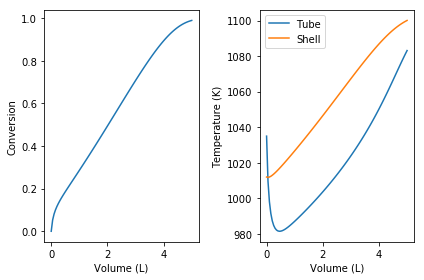

In [1]:
# you have to manually iterate on this value until Tshell[-1] == 1100
Ta_guess = 1012

Y0 = [Fa0, T0, Ta_guess]

from scipy.integrate import odeint
sol = odeint(pfr, Y0, Vspan)

Fa = sol[:, 0]
T = sol[:, 1]
Tshell = sol[:, 2]
print(Tshell[-1])
X = ((Fa - Fa0) * (-1) / Fa0)

plt.subplot(1, 2, 1)
plt.plot(Vspan, X)
plt.xlabel('Volume (L)')
plt.ylabel('Conversion')

plt.subplot(1, 2, 2)
plt.plot(Vspan, T, label='Tube')
plt.plot(Vspan, Tshell, label='Shell')
plt.xlabel('Volume (L)')
plt.ylabel('Temperature (K)')
plt.legend(loc='best')

plt.tight_layout()

-   This is a difficult problem to solve
    -   There is a steep change in T in the tube at the entrance

-   The shooting method is not ideal
    -   It is not always stable

-   But you need an initial guess for the solution otherwise
    -   The solution does not have an intuitive form so it is hard to guess

# Summary

-   This concludes application of the energy balance to the basic reactor types

The key equation for the plug flow reactor is:
<div class="alert alert-warning">
$ \frac{dT}{dV} = \frac{-\Delta H_{Rx}(T) r + \dot{Q}}{\sum F_i C_{P,i}} $
</div>

-   In the nonisothermal PFR we end up with coupled ODEs for the mole and energy balance.
-   It is important to inspect $\dot{Q}$ to make sure the sign convention is correct.